In [2]:
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.utils.data
import cv2
import torch
import torchvision
import os
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import random
batchSize=1
imageSize=[512,512]

In [2]:
print(torchvision.__version__)
print(torch.__version__)

0.14.0
1.13.0


In [11]:
class config:
    ROOT_DIR  = "./resize_512"
    IMAGE_DIR = "./resize_512/image"
    ANNOTATION_DIR =  "./resize_512/json"
    MODEL_DIR = "./resize_512/result/model/"
        
    WIDTH = 512
    HEIGHT = 512


    GPU = torch.device("cuda")
    CPU = torch.device("cpu")

    RESNET_MEAN = (0.485, 0.456, 0.406)
    RESNET_STD = (0.229, 0.224, 0.225)

    IMAGE_RESIZE=(512,512)

    BATCH_SIZE = 2

    MOMENTUM = 0.9
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0005


    MASK_THRESHOLD = 0.5

    NORMALIZE = False 


    USE_SCHEDULER = False

    NUM_EPOCHS = 8


    BOX_DETECTIONS_PER_IMG = 539

    NUM_CLASSES=2
    
    MIN_SCORE = 0.59

In [12]:
import os
import shutil
def demo(path):
    img = [path+"/sample/"+img for img in os.listdir(path+"/sample/")]
    im=Image.open(img[0]).convert("RGB")
    images = F.to_tensor(im)
    images = images.to(config.GPU)
    model_dir = path+"/result/model"
    output_image = path+"/result/test/"
    
    if os.path.exists(output_image):
        shutil.rmtree(output_image)

    os.mkdir(output_image)
    for model_path in os.listdir(model_dir):
        model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,box_detections_per_img=config.BOX_DETECTIONS_PER_IMG)
        in_features=model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor=FastRCNNPredictor(in_features,config.NUM_CLASSES)
        in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer=256
        model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask,hidden_layer,config.NUM_CLASSES)
        model.load_state_dict(torch.load(os.path.join(model_dir, model_path)))
        model.to(config.GPU)# move model to the right device
        model.eval()

        with torch.no_grad():
            pred =model([images.to(config.GPU)])[0]
        all_preds_masks = np.zeros((config.HEIGHT, config.WIDTH))
        for mask in pred['masks'].cpu().detach().numpy():
            all_preds_masks = np.logical_or(all_preds_masks, mask[0] > config.MASK_THRESHOLD)
        plt.imshow(im)
        plt.imshow(all_preds_masks, alpha=0.4)
        plt.title("Predictions")
        plt.show()
        

In [13]:
data_dir = ["resize_512"]



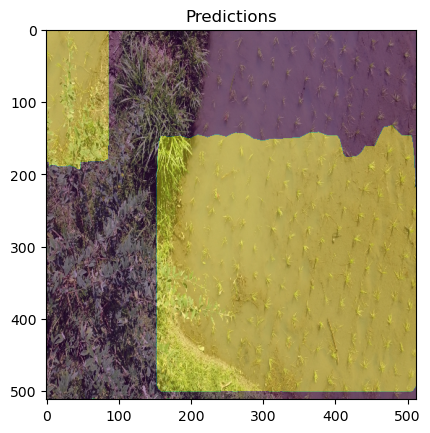

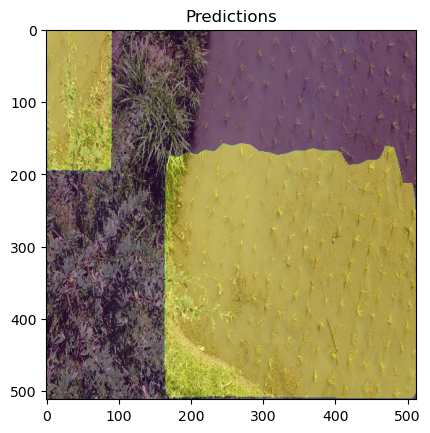

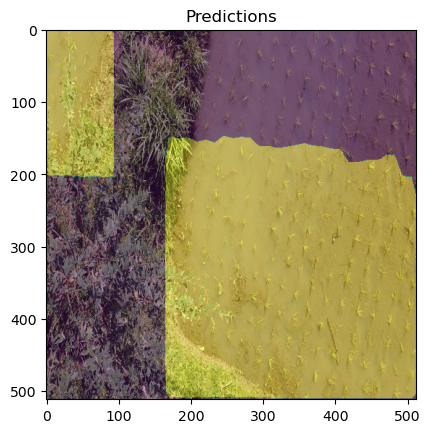

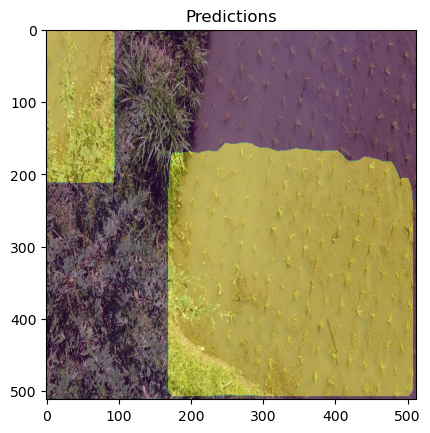

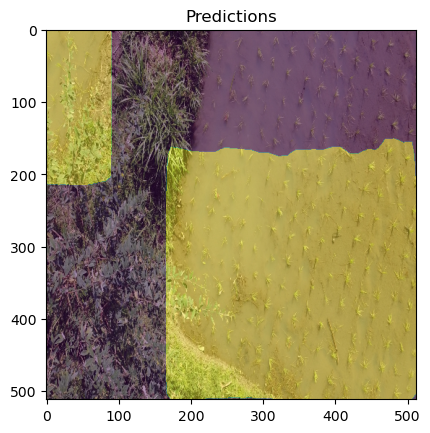

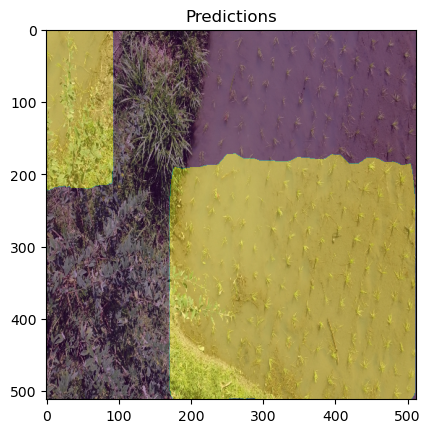

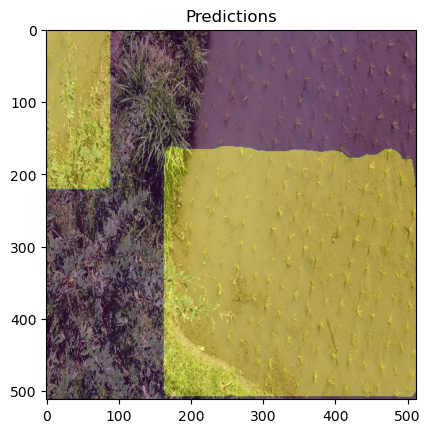

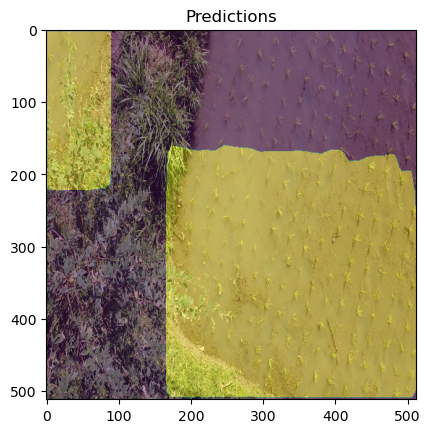

UnpicklingError: invalid load key, '['.

In [14]:
demo(data_dir[0])